# Outlier Detection

Outliers are anomolous points within a dataset. They are points that don't fit within the normal or expected statistical distribution of the dataset and can occur for a variety of reasons such as sensor and measurement errors, poor data sampling techniques and unexpected events. The figure below from McDonald (2021) illustrates an outlier, highlighted in red, within a porosity-permeability dataset.

<img src="figures/OutlierXPlot.png" width="300" />  

Within well logs, outliers can occur due washed out boreholes, tool and sensor issues, rare geological features, and issues in the data acquistion process. It is essential that these outliers are identified and investigated early on in the workflow as they can result in inaccurate predictions by machine learning models.

There are a number of ways to identify outliers within a dataset, some of these are visual such as scatterplots (crossplots) and boxplots, whilst other rely on statistical methods (Z-score) or even unsupervised machine learning algorithms (K Nearest Neighbours). 

Detecting Outliers in the Volve Dataset:
- Z-Score
- Box Plot and IQR
- Using a Caliper Curve
- Automated Outlier Detection

## Importing Libraries & Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

In [2]:
df = pd.read_csv('data/spwla_volve_data.csv')

An initial look at `describe()` function of pandas allows us to see the data range (min and max) for output.

In [3]:
df.describe()

,MD,BS,CALI,DT,DTS,GR,NPHI,RACEHM,RACELM,RHOB,RPCEHM,RPCELM,PHIF,SW,VSH
count,27845.000000,27845.0,27845.000000,5493.000000,5420.000000,27845.000000,27845.000000,27845.000000,27845.000000,27845.000000,27845.000000,27600.000000,27736.000000,27736.000000,2.784400e+04
mean,3816.224960,8.5,8.625875,78.000104,131.027912,38.529140,0.188131,352.689922,97.558930,2.379268,1561.079977,30.041154,0.157434,0.531684,2.724204e-01
std,398.843662,0.0,0.079941,7.730495,13.230939,21.814711,0.053390,1367.355219,395.725094,0.162293,9570.308431,210.915588,0.075957,0.353637,1.872371e-01
min,3223.000000,8.5,8.304900,54.280000,83.574000,6.869100,0.024000,0.197400,0.234900,1.627000,0.139000,0.136600,0.001000,0.043000,1.820000e-15
25%,3503.000000,8.5,8.556900,72.562500,123.403425,21.128200,0.157000,1.856400,1.781000,2.240000,2.148300,1.884000,0.091000,0.201000,1.258000e-01
50%,3713.300000,8.5,8.625000,77.228000,131.864350,35.071000,0.183900,4.035800,3.681200,2.356000,5.136800,4.195400,0.178000,0.433000,2.400000e-01
75%,4057.000000,8.5,8.672000,84.342900,138.017500,49.178300,0.215200,14.929000,8.891000,2.502500,24.687400,14.782650,0.225000,1.000000,3.540000e-01
max,4744.000000,8.5,9.175000,96.277600,186.090800,127.055700,0.541000,6381.099100,2189.603000,3.090000,62290.770000,5571.435100,0.292000,1.000000,1.000000e+00


### Remove Extreme Resistivities
As resistivity values increase, the measurement error can also increase and reliance on the values can become problematic. 

In this dataset, we will remove values above the following limits:
- RACHEM > 60
- RACLEM > 100
- RPCHEM > 100
- RPCLEM > 200

In [4]:
df = df.loc[~((df.RACEHM > 60) | (df.RACELM > 100) | (df.RPCEHM > 100) | (df.RPCELM > 200)),:]

In [5]:
df.describe()

,MD,BS,CALI,DT,DTS,GR,NPHI,RACEHM,RACELM,RHOB,RPCEHM,RPCELM,PHIF,SW,VSH
count,23371.000000,23371.0,23371.000000,5401.000000,5328.000000,23371.000000,23371.000000,23371.000000,23371.000000,23371.000000,23371.000000,23371.000000,23289.000000,23289.000000,2.337000e+04
mean,3807.840734,8.5,8.626972,77.954471,131.044444,41.774969,0.193713,6.597698,4.798570,2.400257,9.789785,6.927095,0.149106,0.605468,2.988932e-01
std,420.122814,0.0,0.084230,7.766778,13.262205,21.796354,0.054881,9.377032,6.176176,0.161100,14.816514,9.586127,0.077235,0.334260,1.883077e-01
min,3223.000000,8.5,8.304900,54.280000,83.574000,6.869100,0.026000,0.197400,0.234900,1.627000,0.139000,0.205300,0.001000,0.087000,1.820000e-15
25%,3468.000000,8.5,8.556900,72.506100,123.382725,26.620000,0.162000,1.688000,1.618600,2.261200,1.885000,1.719800,0.080000,0.287000,1.691250e-01
50%,3660.400000,8.5,8.625000,77.086000,131.985950,38.059700,0.192000,2.898000,2.660600,2.386800,3.789000,2.968000,0.161400,0.569000,2.649000e-01
75%,4082.250000,8.5,8.672000,84.398200,138.138475,52.127450,0.220950,7.279600,5.838000,2.522000,10.251100,8.095750,0.219000,1.000000,3.770750e-01
max,4744.000000,8.5,9.175000,96.277600,186.090800,127.055700,0.541000,59.995000,97.164010,3.090000,99.717000,71.885000,0.282000,1.000000,1.000000e+00


### Convert Logathrithmic Curves
As the resistivity curves have a large range of values from 10s of ohmm to 1000s of ohmm, which is often skewed, it would be best to convert them to a more normal distribution by taking the log base 10 (log10) of the values.

In [6]:
# Select all resistivity curves
res_curves = ['RACEHM', 'RACELM', 'RPCEHM', 'RPCELM']

# Loop through each curve and transform it
for res in res_curves:
    df[f'{res}_l10'] = np.log10(df[res])
    
    # Drop out the original columns, so only the transformed curves are present.
    df.drop(columns=[res],inplace=True)
    
df.head()

,wellName,MD,BS,CALI,DT,DTS,GR,NPHI,RHOB,PHIF,SW,VSH,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10
0,15/9-F-1 A,3431.0,8.5,8.6718,86.9092,181.2241,53.9384,0.3222,2.7514,0.02,1.0,0.6807,-0.293794,-0.072784,-0.189700,-0.189297
1,15/9-F-1 A,3431.1,8.5,8.6250,86.4334,181.1311,57.2889,0.3239,2.7978,0.02,1.0,0.7316,-0.328364,-0.089109,-0.122456,-0.182435
2,15/9-F-1 A,3431.2,8.5,8.6250,85.9183,180.9487,59.0455,0.3277,2.8352,0.02,1.0,0.7583,-0.299989,-0.094312,-0.059583,-0.163803
3,15/9-F-1 A,3431.3,8.5,8.6250,85.3834,180.7211,58.2550,0.3357,2.8557,0.02,1.0,0.7462,-0.218388,-0.097779,-0.024522,-0.101659
4,15/9-F-1 A,3431.4,8.5,8.6250,84.8484,180.4930,59.4569,0.3456,2.8632,0.02,1.0,0.7646,-0.147825,-0.108909,0.016365,-0.058986


From the above table, we can now see that the new columns have been added to the dataframe.

### Boxplots
Boxplots are a visual tool for identifying outliers within a dataset.......

The simplest method for calling a boxplot is using `.plot(kind='box)` on the dataframe. However, as you will see, this will plot all of the columns on one scale. This allows you to see curves which have a larger range, but it obscures those with a smaller range such as VSH.

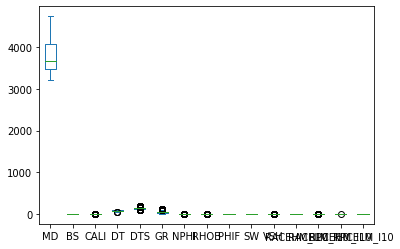

In [7]:
df.plot(kind='box')
plt.show()

To make the plots easier to view and understand, we can call upon the boxplot from the seaborn library and loop over each of the columns in the dataframe.

In [8]:
def make_boxplot(welldata, inputs):

    num_inputs = len(inputs)

    fig, axs = plt.subplots(1, num_inputs, figsize=(20,10))

    for i, (ax, curve) in enumerate(zip(axs.flat, inputs), 1):
        sns.boxplot(y=welldata[curve], ax=ax, color='cornflowerblue', showmeans=True,  
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
               flierprops={'marker':'o', 
                          'markerfacecolor':'darkgreen',
                          'markeredgecolor':'darkgreen'})
        
        ax.set_title(inputs[i-1])
        ax.set_ylabel('')

    plt.subplots_adjust(hspace=0.15, wspace=1.25)
    plt.show()

Rerun the function for each of the log curves within the dataframe

['MD', 'BS', 'CALI', 'DT', 'DTS', 'GR', 'NPHI', 'RHOB', 'PHIF', 'SW', 'VSH', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10']
Total Number of Samples: 23371


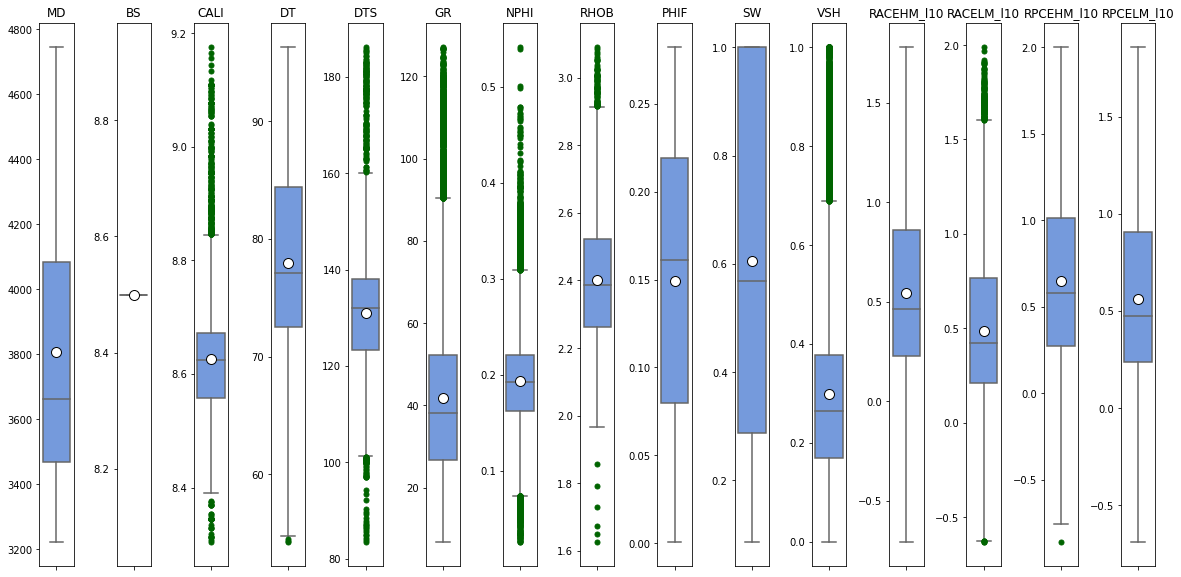

In [9]:
inputs = list(df.columns)
inputs.pop(0) # remove the well name from the columns list
print(inputs)
print(f'Total Number of Samples: {len(df)}')
make_boxplot(df, inputs)

### Crossplots

Another method for identifying outliers is to use crossplots. These involve plotting one logging measurement against another. A thrid logging measurement can be used to add colour to the plot to allow easy identification of outliers.

In this example, we will use a function to make a scatter plot (crossplot) of density vs neutron porosity data, which will be coloured by caliper.

In [10]:
grouped = df.groupby('wellName')

In [11]:
import matplotlib
def make_xplot(welldata, xvar, yvar,  color, rows=1, cols=1, xscale=[0,1], yscale=[0,1], vmin=0, vmax=1):
    fig, axs = plt.subplots(rows, cols, figsize=(25,5))
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
    
    for (name, welldata), ax in zip(grouped, axs.flat):
        sc = ax.scatter(x=xvar, y=yvar, data=welldata, s=5, c=color, vmin=vmin, vmax=vmax, cmap=cmap)
#         sns.scatterplot(x=xvar, y=yvar, data=welldata, hue=color, ax=ax, legend=False, palette="viridis")

        ax.set_ylim(yscale[0], yscale[1])
        ax.set_xlim(xscale[0], xscale[1])
        ax.set_ylabel(yvar)
        ax.set_xlabel(xvar)
        ax.set_title(name)
        
        fig.colorbar(sc, ax=ax)
    plt.tight_layout()
    plt.show()

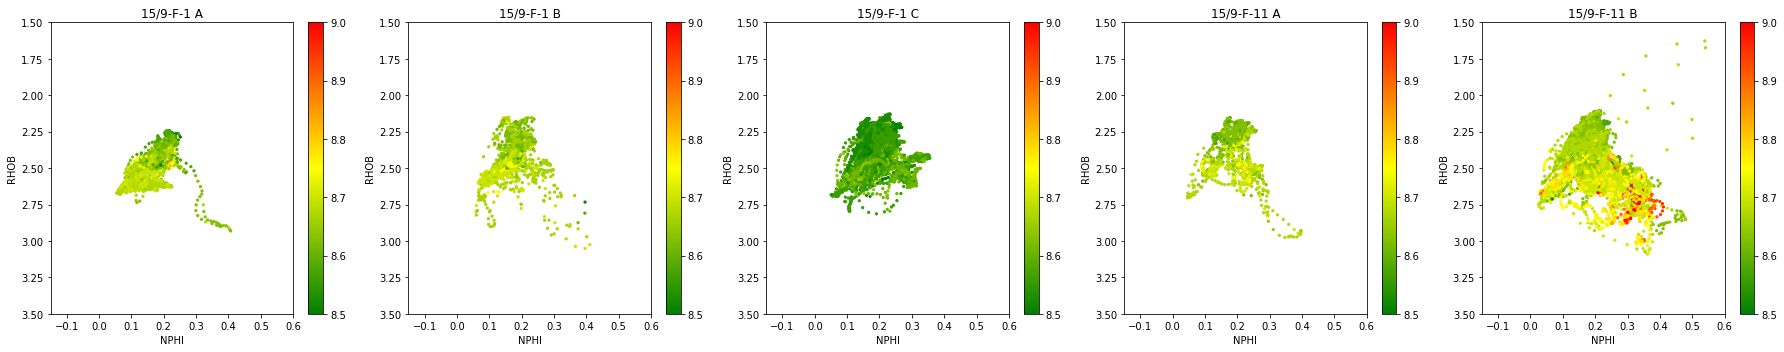

In [12]:
make_xplot(grouped, 'NPHI', 'RHOB', 'CALI', 1, 5, [-0.15, 0.6], [3.5,1.5], 8.5, 9)

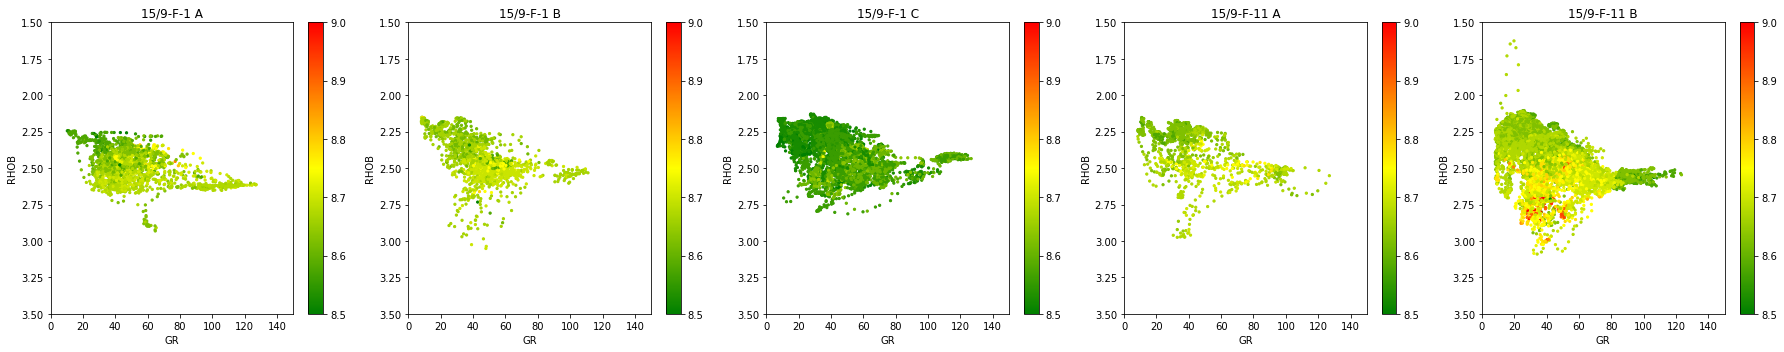

In [13]:
make_xplot(grouped, 'GR', 'RHOB', 'CALI', 1, 5, [0, 150], [3.5,1.5], 8.5, 9)

There are a few points affected by badhole conditions, however, most tools are capable of compensating for a certain degree of hole enlargement and rugosity. 

For the purposes of this example and to illustrate the process, we will remove any points that are over 9". That is 0.5" over guage.
Any points that are less than 8.5" will also be removed.

In [14]:
df = df[(df['CALI'] >= 8.5) & (df['CALI'] <= 9)]
df.describe()

,MD,BS,CALI,DT,DTS,GR,NPHI,RHOB,PHIF,SW,VSH,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10
count,22402.000000,22402.0,22402.000000,5397.000000,5324.000000,22402.000000,22402.000000,22402.000000,22320.000000,22320.000000,22401.000000,22402.000000,22402.000000,22402.000000,22402.000000
mean,3824.435533,8.5,8.631899,77.950271,131.039877,42.202676,0.192366,2.403091,0.147297,0.601908,0.302230,0.565638,0.501850,0.670684,0.584120
std,418.788133,0.0,0.074291,7.768036,13.265878,21.856708,0.054969,0.161315,0.076835,0.337976,0.188829,0.457538,0.389418,0.523302,0.465428
min,3223.000000,8.5,8.500000,54.280000,83.574000,7.008700,0.026000,1.627000,0.001000,0.087000,0.000100,-0.704653,-0.629117,-0.856985,-0.687611
25%,3493.000000,8.5,8.578000,72.505500,123.380375,26.863000,0.161000,2.263200,0.079000,0.281575,0.171000,0.243992,0.225051,0.296884,0.253998
50%,3673.300000,8.5,8.625000,77.081000,131.979850,38.455600,0.190100,2.393900,0.156700,0.531000,0.267800,0.485153,0.432937,0.597827,0.497483
75%,4118.375000,8.5,8.672000,84.398200,138.129825,52.736850,0.219000,2.524000,0.217000,1.000000,0.381500,0.875329,0.778437,1.028313,0.920610
max,4744.000000,8.5,9.000000,96.277600,186.090800,127.055700,0.541000,3.090000,0.282000,1.000000,1.000000,1.778115,1.987505,1.998769,1.856638


## Identifying Outliers Using Automated Methods

There are a number of unsupervised machine learning methods that can be used to identify anomalies / outliers within a dataset.

In this notebook we will look at three common methods:
- Isolation Forest (IF)
- One Class SVM (SVM)
- Local Outlier Factor (LOF)

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

# Create a copy of the dataframe so that the original remanins untouched and extract the required curves
anomaly_df = df[['wellName', 'MD', 'CALI', 'GR', 'NPHI', 'RHOB', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10', 'PHIF', 'SW', 'VSH']].copy()

# Drop any null values. This method drops the entire row of data if one of the cells in that row
# contains a null (NaN) value
anomaly_df.dropna(inplace=True)

# Define the inputs for the anomaly detection
anomaly_inputs = ['NPHI', 'RHOB', 'CALI', 'GR']

# Setup the models, each will have a contamination (outlier) fraction of 0.1
# The random_state is set to allow repeatable results for the Isolation Forest. This can be omitted if required.
model_IF = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.1), max_features=1.0, random_state=42)
model_SVM = OneClassSVM(nu=0.10)
model_lof = LocalOutlierFactor(contamination=0.1, novelty=True)

models = {'IF':model_IF, 
         'SVM': model_SVM,
         'LOF': model_lof}

for name, model in models.items():
    print(f'Fitting: {name}')
    model.fit(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly_scores'] = model.decision_function(anomaly_df[anomaly_inputs])
    anomaly_df[f'{name}_anomaly'] = model.predict(anomaly_df[anomaly_inputs])

print('Model Fitting Complete')
anomaly_df.head(5)

Fitting: IF
Fitting: SVM
Fitting: LOF
Model Fitting Complete


,wellName,MD,CALI,GR,NPHI,RHOB,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10,PHIF,SW,VSH,IF_anomaly_scores,IF_anomaly,SVM_anomaly_scores,SVM_anomaly,LOF_anomaly_scores,LOF_anomaly
0,15/9-F-1 A,3431.0,8.6718,53.9384,0.3222,2.7514,-0.293794,-0.072784,-0.189700,-0.189297,0.02,1.0,0.6807,-0.001228,-1,1.796244,1,-0.120150,-1
1,15/9-F-1 A,3431.1,8.6250,57.2889,0.3239,2.7978,-0.328364,-0.089109,-0.122456,-0.182435,0.02,1.0,0.7316,-0.034982,-1,0.139234,1,-0.416300,-1
2,15/9-F-1 A,3431.2,8.6250,59.0455,0.3277,2.8352,-0.299989,-0.094312,-0.059583,-0.163803,0.02,1.0,0.7583,-0.039916,-1,-0.163438,-1,-0.469561,-1
3,15/9-F-1 A,3431.3,8.6250,58.2550,0.3357,2.8557,-0.218388,-0.097779,-0.024522,-0.101659,0.02,1.0,0.7462,-0.047247,-1,-0.092418,-1,-0.478815,-1
4,15/9-F-1 A,3431.4,8.6250,59.4569,0.3456,2.8632,-0.147825,-0.108909,0.016365,-0.058986,0.02,1.0,0.7646,-0.065941,-1,-0.192646,-1,-0.715623,-1


We can now check the performance of each of the models using density-neturon crossplots.
This is achieved using Seaborn's FacetGrid and mapping a scatter plot to it.

Outlier Method: IF
Number of anomalous values 2232
Number of non anomalous values  20088
Total Number of Values: 22320
Outlier Method: SVM
Number of anomalous values 2232
Number of non anomalous values  20088
Total Number of Values: 22320
Outlier Method: LOF
Number of anomalous values 2027
Number of non anomalous values  20293
Total Number of Values: 22320


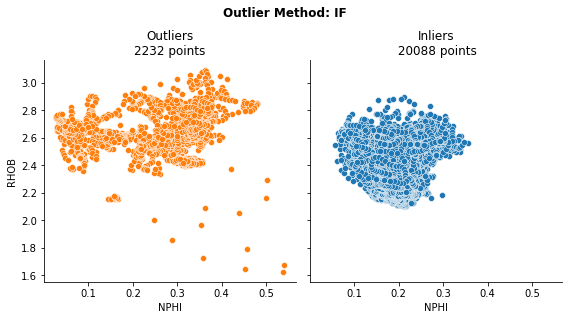

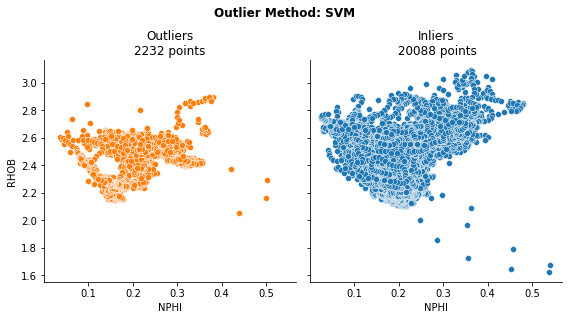

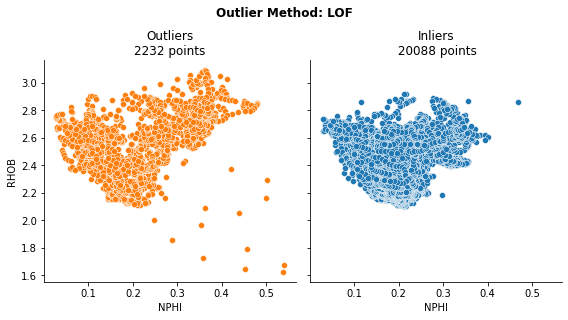

In [16]:
for name in models.keys():
    print(f'Outlier Method: {name}')
    method = f'{name}_anomaly'
    print(f"Number of anomalous values {len(anomaly_df[anomaly_df[method]==-1])}")
    print(f"Number of non anomalous values  {len(anomaly_df[anomaly_df[method]== 1])}")
    print(f'Total Number of Values: {len(anomaly_df)}')

    g = sns.FacetGrid(anomaly_df, col=method, height=4, hue=method, hue_order=[1,-1])
    g.map(sns.scatterplot, 'NPHI', 'RHOB')
    g.fig.suptitle(f'Outlier Method: {name}', y=1.10, fontweight='bold')

    axes = g.axes.flatten()
    axes[0].set_title(f"Outliers\n{len(anomaly_df[anomaly_df['IF_anomaly']== -1])} points")
    axes[1].set_title(f"Inliers\n {len(anomaly_df[anomaly_df['IF_anomaly']==  1])} points")

plt.show()

It appears that the IF method is providing a better result, followed by LOF and then SVM.
Most of the outliers on the right hand side of the plot are removed in the first two methods.

We can look at the data in more detail for each of the well for each method. 

Outlier Method: IF
Number of anomalous values 2232
Number of non anomalous values  20088
Total Number of Values: 22320
Outlier Method: SVM
Number of anomalous values 2232
Number of non anomalous values  20088
Total Number of Values: 22320
Outlier Method: LOF
Number of anomalous values 2027
Number of non anomalous values  20293
Total Number of Values: 22320


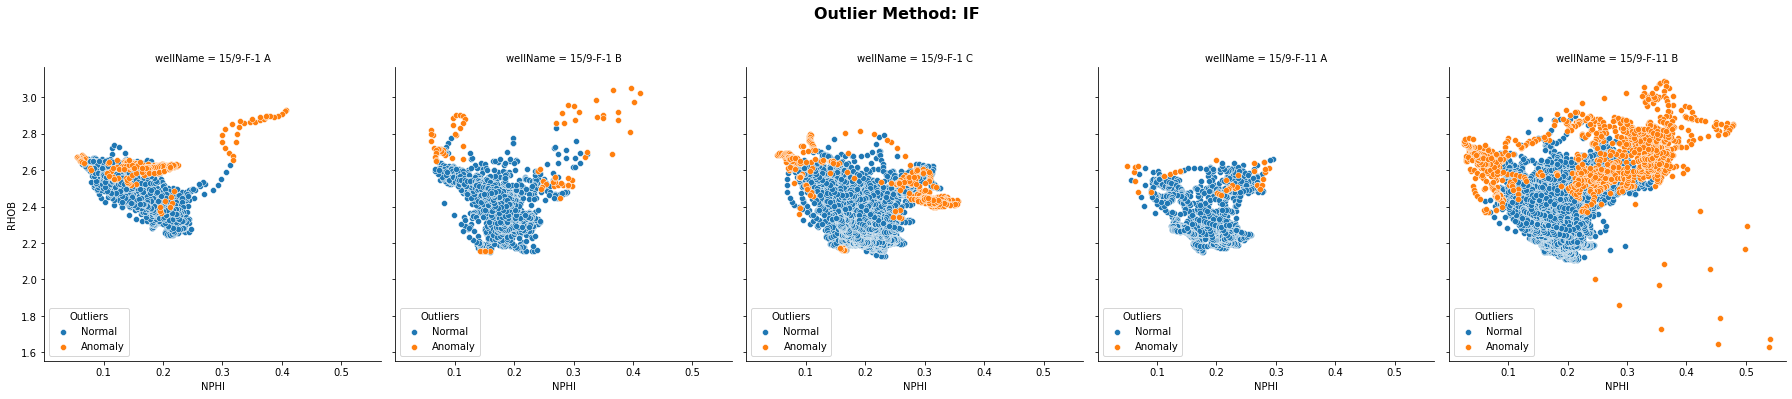

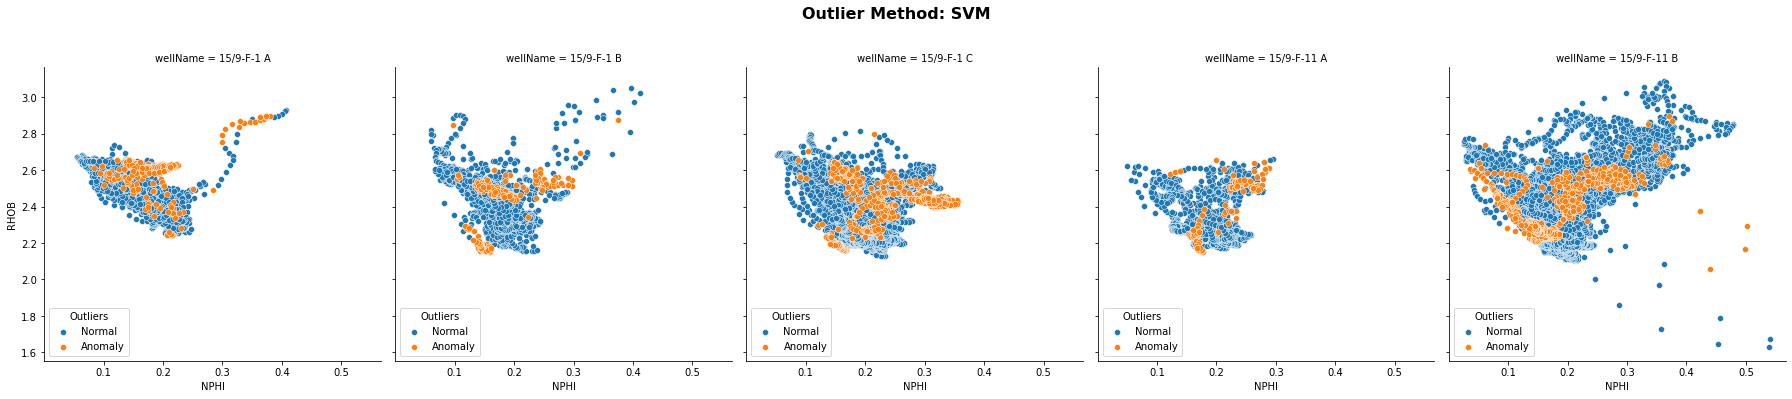

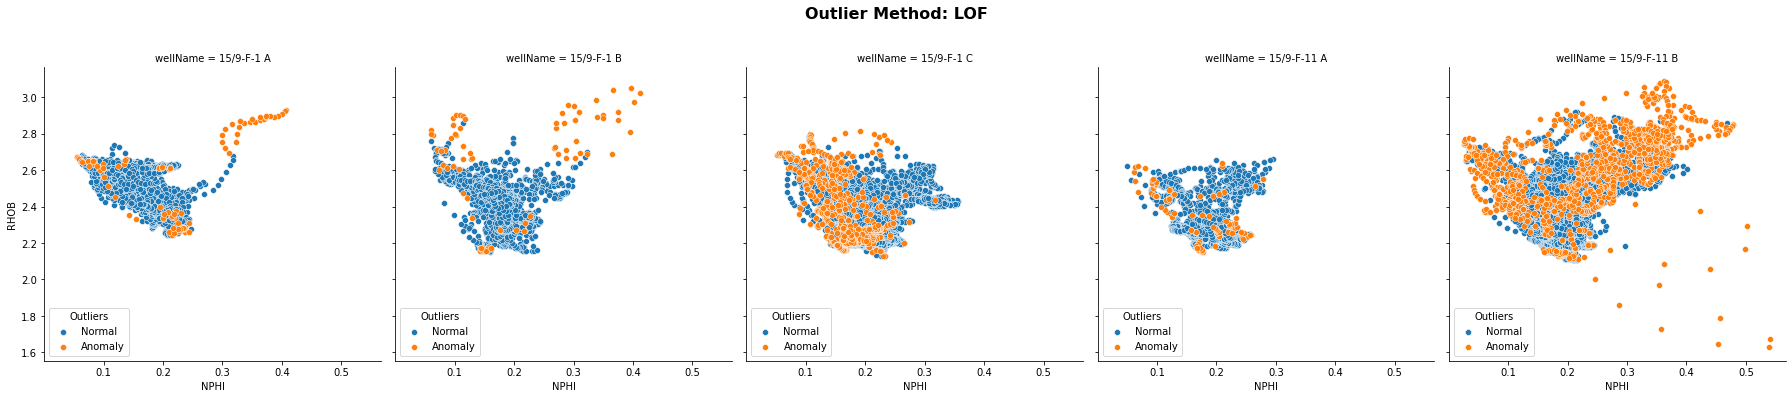

In [17]:
for name in models.keys():
    print(f'Outlier Method: {name}')
    method = f'{name}_anomaly'
    print(f"Number of anomalous values {len(anomaly_df[anomaly_df[method]==-1])}")
    print(f"Number of non anomalous values  {len(anomaly_df[anomaly_df[method]== 1])}")
    print(f'Total Number of Values: {len(anomaly_df)}')

    g = sns.FacetGrid(anomaly_df, col='wellName', hue=method, height=5, hue_order=[1,-1])
    g.map(sns.scatterplot, 'NPHI', 'RHOB')
    
    g.fig.suptitle(f'Outlier Method: {name}', y=1.10, fontweight='bold', fontsize=16)

    axes = g.axes.flatten()
    for ax in axes:
        ax.legend(title='Outliers', loc='lower left', labels=['Normal', 'Anomaly'])

plt.show()


## Log Plots
To validate where the outliers have been detected, we can generate simple log plots for each method and for each well.

In [18]:
def create_outlier_plot(wellname, dataframe, curves_to_plot, depth_curve, outlier_method, log_curves=[]):
    num_tracks = len(curves_to_plot)
    
    outlier_shading = dataframe[outlier_method]
    
    fig, ax = plt.subplots(nrows=1, ncols=num_tracks, figsize=(num_tracks*2, 10))
    fig.suptitle(f'{wellname}   -   {outlier_method}', fontsize=20, y=1.05)
    
    for i, curve in enumerate(curves_to_plot):
        
        
        ax[i].plot(dataframe[curve], depth_curve)
        
        ax[i].fill_betweenx(depth_curve, dataframe[curve].min(), dataframe[curve].max(), where=outlier_shading>= 1, color='green', alpha=0.2)
        ax[i].fill_betweenx(depth_curve, dataframe[curve].min(), dataframe[curve].max(), where=outlier_shading<= -1, color='red', alpha=0.2)
        
        ax[i].set_title(curve, fontsize=14, fontweight='bold')
        ax[i].set_ylim(depth_curve.max(), depth_curve.min())
        ax[i].grid(which='major', color='lightgrey', linestyle='-')

        
        if i == 0:
            ax[i].set_ylabel('DEPTH (m)', fontsize=18, fontweight='bold')
        else:
            plt.setp(ax[i].get_yticklabels(), visible = False)
        
        # Check to see if we have any logarithmic scaled curves
        if curve in log_curves:
            ax[i].set_xscale('log')
            ax[i].grid(which='minor', color='lightgrey', linestyle='-')
        
        
    
    plt.tight_layout()
    plt.show()

Before plotting the data we can make things easier by splitting up the dataframe into multiple dataframe based on the well name

In [19]:
#Creating empty lists to story the dataframes and wellnames in
dfs_wells = []
wellnames = []

#Split up the data by well
for well, data in anomaly_df.groupby('wellName'):
    dfs_wells.append(data)
    wellnames.append(well)
    
# Selecting the curves that we want to plot
curves_to_plot = ['CALI', 'GR', 'NPHI', 'RHOB', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10', 'PHIF', 'SW', 'VSH']


Once the dataframe has been split up by well, we can use the index number of the list to access the required data.

If we loop through the wellnames list we can get the index number and the associated wellname. This method using the index of the same list rather than the enumerate method seen in Notebook 1.1.

In [20]:
print('Wellname \t Index')

for well in wellnames:
    print(f'{well} \t{wellnames.index(well)}')

Wellname 	 Index
15/9-F-1 A 	0
15/9-F-1 B 	1
15/9-F-1 C 	2
15/9-F-11 A 	3
15/9-F-11 B 	4


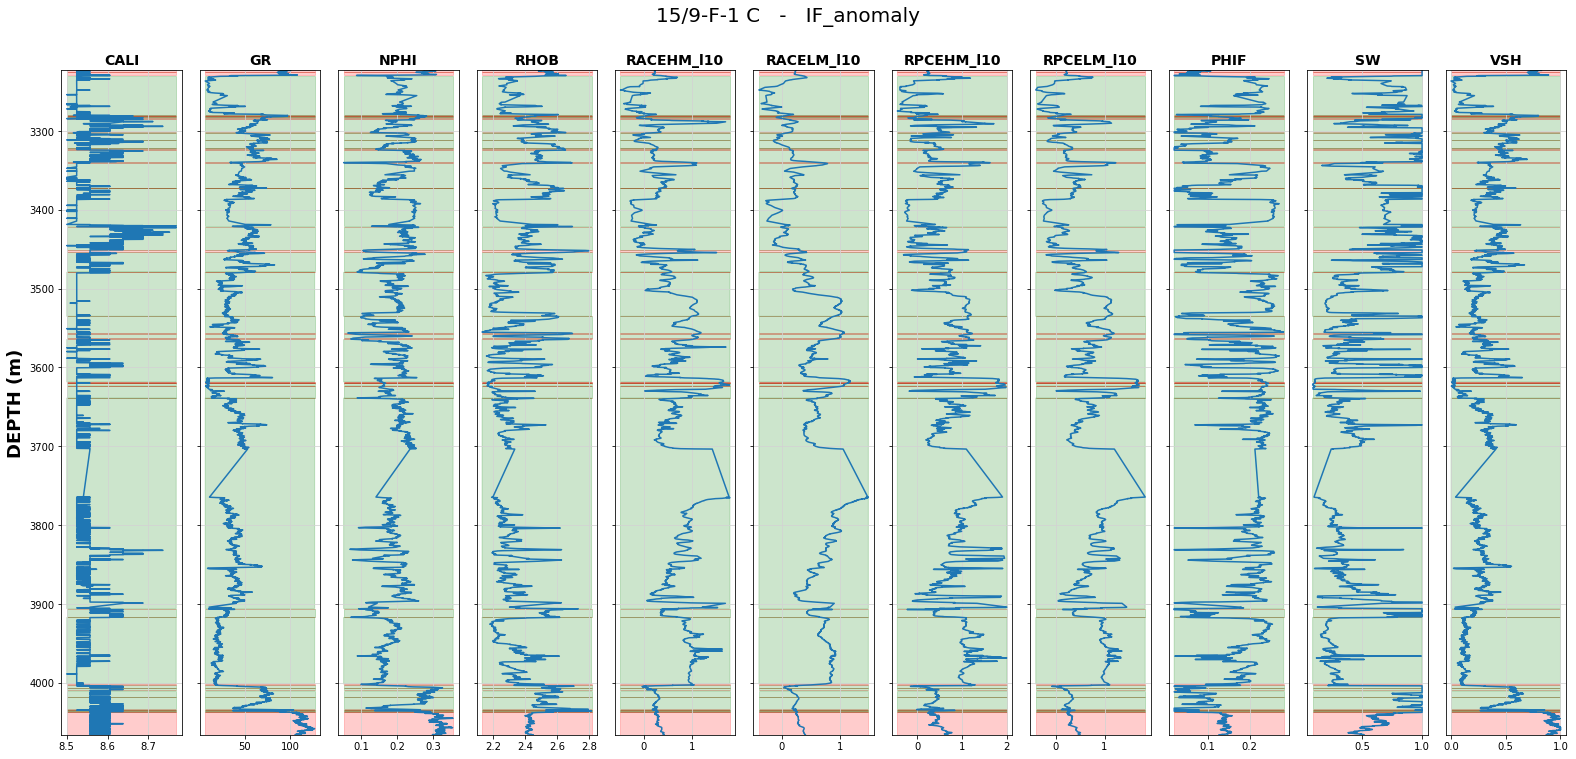

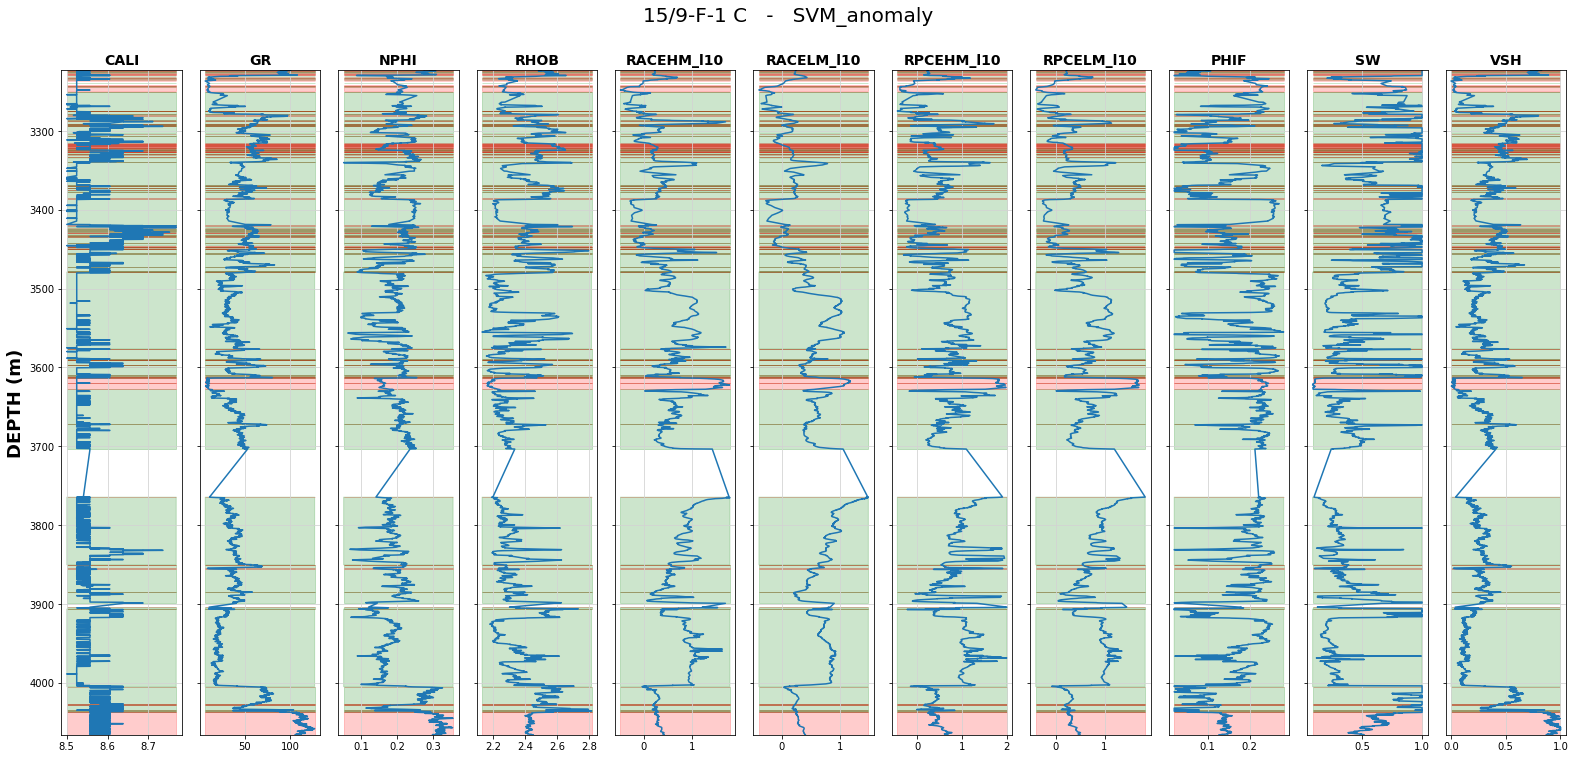

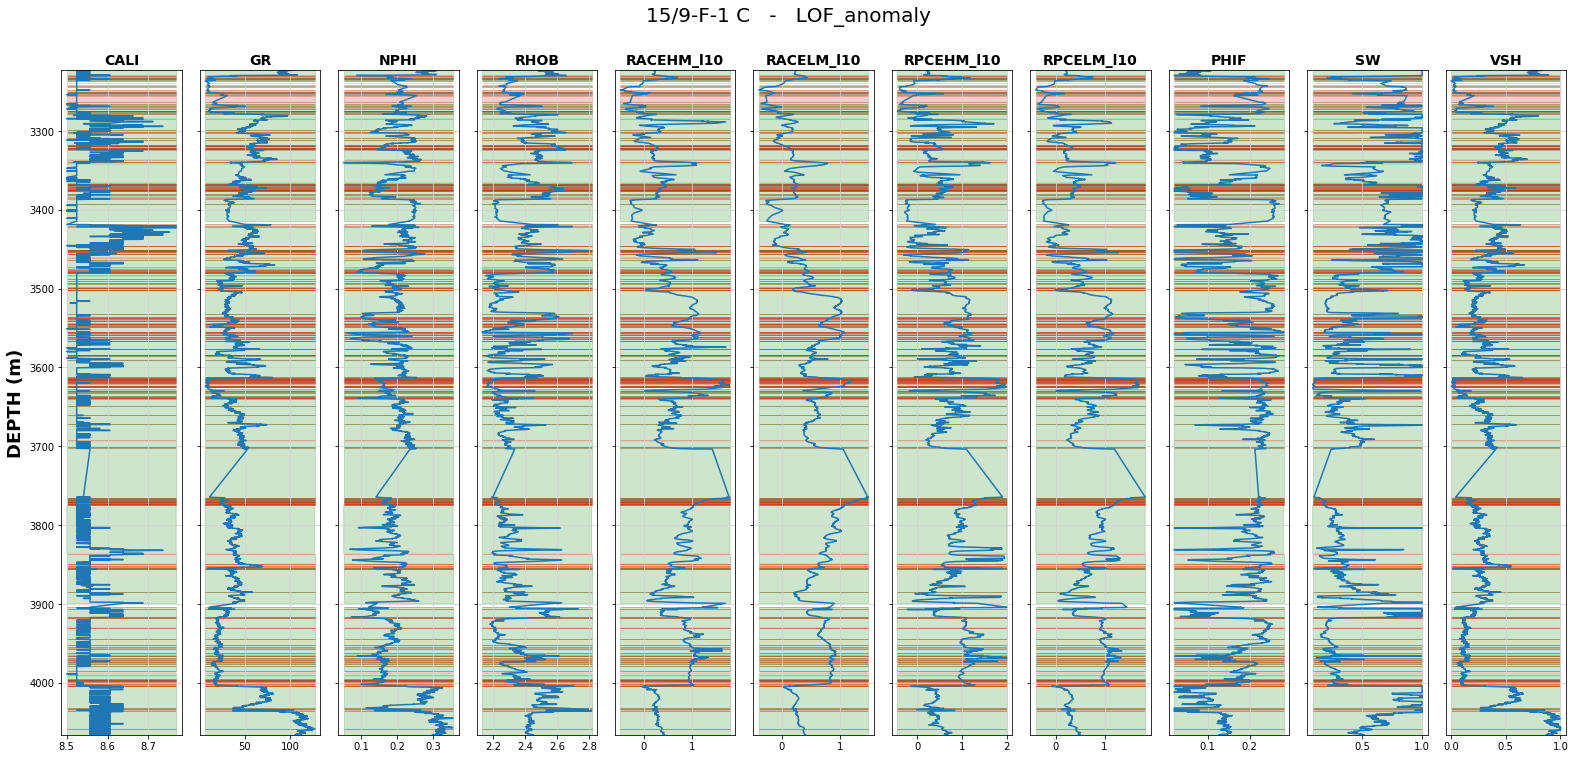

In [21]:
# Select the well by index
well = 2

# Call the function for each method:
create_outlier_plot(wellnames[well], dfs_wells[well], curves_to_plot, dfs_wells[well]['MD'], 'IF_anomaly')
create_outlier_plot(wellnames[well], dfs_wells[well], curves_to_plot, dfs_wells[well]['MD'], 'SVM_anomaly')
create_outlier_plot(wellnames[well], dfs_wells[well], curves_to_plot, dfs_wells[well]['MD'], 'LOF_anomaly')

## Outputing the Results
Now that we have a clean dataset, we can export it to the required files.

To do this, we first need to create our temporary dataframe were we only use data that has been identified as inliers by the Isolation Forest algorithm. Once these points have been removed, we can then create our output dataframe.


In [21]:
# Create a temporary dataframe that contains only "good" data points highlighted by Isolation Forest
temp_df = anomaly_df.loc[anomaly_df['IF_anomaly'] == 1]

# Create the output dataframe with the required curves, including MD and wellName.
# This allows easy plotting of the data at a later stage.
output_df = temp_df[['wellName', 'MD', 'CALI', 'GR', 'RHOB', 'NPHI', 'RACEHM_l10', 'RACELM_l10', 'RPCEHM_l10', 'RPCELM_l10',
                    'PHIF', 'SW', 'VSH']]


### Unsupervised Learning File

Creation of the Unsupervised Learning file is simple, we export the entire dataframe.

In [22]:
# Unsupervised Learning File
output_df.to_csv('processed_data/UL_Features.csv')

In [23]:
output_df

,wellName,MD,CALI,GR,RHOB,NPHI,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10,PHIF,SW,VSH
32,15/9-F-1 A,3434.2,8.6250,72.7456,2.6270,0.3134,-0.146667,-0.227165,0.233326,0.004794,0.0200,1.000,0.9659
33,15/9-F-1 A,3434.3,8.6250,72.5227,2.5898,0.3055,-0.104964,-0.233959,0.332459,0.019116,0.0422,1.000,0.9626
34,15/9-F-1 A,3434.4,8.6249,70.1513,2.5523,0.2982,-0.075514,-0.239804,0.410355,0.042654,0.0648,1.000,0.9268
35,15/9-F-1 A,3434.5,8.5781,64.3046,2.5186,0.2933,-0.061530,-0.242528,0.429914,0.054000,0.0851,1.000,0.8382
36,15/9-F-1 A,3434.6,8.5781,58.7215,2.4902,0.2836,-0.052860,-0.242452,0.413484,0.056829,0.1022,0.882,0.7535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27834,15/9-F-11 B,4743.0,8.7810,35.3900,2.5370,0.1170,0.280806,0.288026,0.462548,0.320146,0.0960,0.790,0.3040
27835,15/9-F-11 B,4743.1,8.7810,31.8830,2.5430,0.1090,0.309630,0.287354,0.469969,0.327359,0.0910,0.820,0.2690
27836,15/9-F-11 B,4743.2,8.7810,27.9650,2.5410,0.1040,0.312177,0.290257,0.500099,0.346549,0.0890,0.809,0.2300
27843,15/9-F-11 B,4743.9,8.7260,12.6170,2.4270,0.1140,0.235276,0.247237,0.222716,0.204120,0.1320,0.736,0.0760


### Supervised Learning File
To prepare the Supervised Learning file, we need to carry out a few more steps. 

First, we split out data up into the training features and target features (SW, PHIF & VSH). In situations where we are using Sklearn for prediction, we would typically only specify one feature for prediction. However, for the example, we will be setting three target features.

In [24]:
# Get a list of all of the columns in the 
data_features = list(output_df.columns)

# Specify our target features,
# in this case Water Sat. Porosity and VShale.
target_features = ['SW', 'PHIF', 'VSH']

# Remove the target features from the data features list
for item in target_features:
    data_features.remove(item)

# target_feature = 'SW'

X = output_df[data_features]
y = output_df[target_features]

When we check the training features (X), we can see we have all of the required columns.

In [25]:
X.head()

,wellName,MD,CALI,GR,RHOB,NPHI,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10
32,15/9-F-1 A,3434.2,8.6250,72.7456,2.6270,0.3134,-0.146667,-0.227165,0.233326,0.004794
33,15/9-F-1 A,3434.3,8.6250,72.5227,2.5898,0.3055,-0.104964,-0.233959,0.332459,0.019116
34,15/9-F-1 A,3434.4,8.6249,70.1513,2.5523,0.2982,-0.075514,-0.239804,0.410355,0.042654
35,15/9-F-1 A,3434.5,8.5781,64.3046,2.5186,0.2933,-0.061530,-0.242528,0.429914,0.054000
36,15/9-F-1 A,3434.6,8.5781,58.7215,2.4902,0.2836,-0.052860,-0.242452,0.413484,0.056829


We can also check the head of the target features (y):

In [26]:
y.head()

,SW,PHIF,VSH
32,1.000,0.0200,0.9659
33,1.000,0.0422,0.9626
34,1.000,0.0648,0.9268
35,1.000,0.0851,0.8382
36,0.882,0.1022,0.7535


Next, we need to split the data into training and test data using Sklearn's train_test_split module. 
For this example, we will use a training size of 70%, which leaves 30% for validating and tuning the model. `random_state` has been set to a fixed value to allow reproducible results for this workshop. If you want to randomise the values each time, you can remove this method input.

In [27]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation datasets
# Setting training size to 70%
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7,
                                                   random_state=42, 
                                                   shuffle=True)
# Export the Data to csv files:
X_train.to_csv('processed_data/SL_Train_Features.csv', index=True)
X_test.to_csv('processed_data/SL_Val_Features.csv', index=True)
y_train.to_csv('processed_data/SL_Train_Target.csv', index=True, header=target_features)
y_test.to_csv('processed_data/SL_Val_Target.csv', index=True, header=target_features)

Once the model has been trained and validated, we can apply that model on unseen data and test the true performance of the model.

In [28]:
# Test Data
test_data_df = output_df.loc[output_df['wellName']=='15/9-F-11 B']
test_data_df.head()

,wellName,MD,CALI,GR,RHOB,NPHI,RACEHM_l10,RACELM_l10,RPCEHM_l10,RPCELM_l10,PHIF,SW,VSH
13971,15/9-F-11 B,3356.7,8.578,95.382,2.565,0.237,0.309417,0.319314,0.329805,0.296007,0.057,1.0,0.786
13972,15/9-F-11 B,3356.8,8.578,94.400,2.565,0.238,0.307496,0.317227,0.335057,0.297979,0.057,1.0,0.777
13973,15/9-F-11 B,3356.9,8.557,92.814,2.568,0.243,0.304275,0.318272,0.332842,0.297542,0.056,1.0,0.764
13984,15/9-F-11 B,3358.0,8.578,92.779,2.560,0.250,0.296665,0.302331,0.311754,0.278067,0.060,1.0,0.763
13985,15/9-F-11 B,3358.1,8.578,92.760,2.559,0.251,0.295567,0.299289,0.312177,0.275772,0.061,1.0,0.763


Exporting the test well data is done in the same way but calling upon `.to_csv()`

In [29]:
test_data_df.to_csv('processed_data/SL_Test_Features.csv', columns=data_features)
test_data_df.to_csv('processed_data/SL_Test_Target.csv', columns=['wellName', 'MD', 'SW', 'VSH', 'PHIF'])

# Summary

In this notebook we have covered what outliers are and methods for identifying them using plots and unsupervised learning algorithms. Once the outliers have been identified they can be removed. This is done using a combination of the methods and domain expertise. If points are thrown away blindly, you could be throwing away valuable data.